In [1]:
import os
import ast
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [2]:
# file_path = kagglehub.dataset_download("neelshah18/arxivdataset")
# arxiv_df = pd.read_json(os.path.join(file_path, 'arxivData.json'))
file_path = "~/.cache/kagglehub/datasets/neelshah18/arxivdataset/versions/2/arxivData.json"
arxiv_df = pd.read_json(file_path)
arxiv_df = arxiv_df.drop(columns=['author', 'day', 'id', 'link', 'month', 'year'])
arxiv_df['tag'] = arxiv_df['tag'].apply(ast.literal_eval)
arxiv_df = arxiv_df.explode('tag').reset_index(drop=True)
arxiv_df['tag'] = arxiv_df['tag'].apply(lambda x: x['term'])
arxiv_df['text'] = arxiv_df['title'] + ' ' + arxiv_df['summary']
arxiv_df = arxiv_df.drop(columns=['title', 'summary'])
arxiv_df = arxiv_df[['text', 'tag']]

In [3]:
arxiv_df.head(15)

text      tag
0   Dual Recurrent Attention Units for Visual Ques...    cs.AI
1   Dual Recurrent Attention Units for Visual Ques...    cs.CL
2   Dual Recurrent Attention Units for Visual Ques...    cs.CV
3   Dual Recurrent Attention Units for Visual Ques...    cs.NE
4   Dual Recurrent Attention Units for Visual Ques...  stat.ML
5   Sequential Short-Text Classification with Recu...    cs.CL
6   Sequential Short-Text Classification with Recu...    cs.AI
7   Sequential Short-Text Classification with Recu...    cs.LG
8   Sequential Short-Text Classification with Recu...    cs.NE
9   Sequential Short-Text Classification with Recu...  stat.ML
10  Multiresolution Recurrent Neural Networks: An ...    cs.CL
11  Multiresolution Recurrent Neural Networks: An ...    cs.AI
12  Multiresolution Recurrent Neural Networks: An ...    cs.LG
13  Multiresolution Recurrent Neural Networks: An ...    cs.NE
14  Multiresolution Recurrent Neural Networks: An ...  stat.ML

In [65]:
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split

class ArticleDataset(Dataset):
    def __init__(self, data, tokenizer, label_encoder, max_length=256):
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder
        self.max_length = max_length
        self.texts = data['text'].to_list()
        self.labels = torch.tensor(self.label_encoder.fit_transform(data['tag'].to_list()))
        assert len(self.texts) == len(self.labels)
        
    def __getitem__(self, index):
        encoded_text = self.tokenizer(
            self.texts[index],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return encoded_text['input_ids'].squeeze(0), encoded_text['attention_mask'].squeeze(0), self.labels[index]

    def __len__(self):
        return len(self.labels)

In [66]:
import torch.optim as optim
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")
label_encoder = LabelEncoder()

dataset = ArticleDataset(arxiv_df, tokenizer, label_encoder)

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=len(label_encoder.classes_))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm

train_losses = []
train_accuracies = []

os.makedirs("checkpoints", exist_ok=True)

def train(model, epochs):
    model.train()
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        total_loss = 0
        correct = 0
        total = 0

        for input_ids, attn_mask, labels in tqdm(train_loader):
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attn_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Средний loss и accuracy за эпоху
        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

        # График потерь
        clear_output(True)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, marker='o')
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")

        # График точности
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, marker='o', color='green')
        plt.title("Training Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")

        plt.tight_layout()
        plt.show()

        # Сохраняем чекпойнт
        if (epoch + 1) % 4 == 0:
            checkpoint_path = f"checkpoints/epoch_{epoch+1}.pt"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")

    return model

In [83]:
import json

dict_to_save = {}
for ind, el in enumerate(label_encoder.classes_):
    dict_to_save[ind] = el

with open('checkpoints/labels_info.json', 'w') as f:
    json.dump(dict_to_save, f)

In [72]:
for param in model.distilbert.parameters():
    param.requires_grad = False

# Размораживаем только последний слой
# for param in model.distilbert.transformer.layer[-1].parameters():
#     param.requires_grad = True

# Также размораживаем классификационную голову
for param in model.classifier.parameters():
    param.requires_grad = True
    
def count_trainable_params(model):
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total

print("Обучаемых параметров:", count_trainable_params(model))

Обучаемых параметров: 2353909


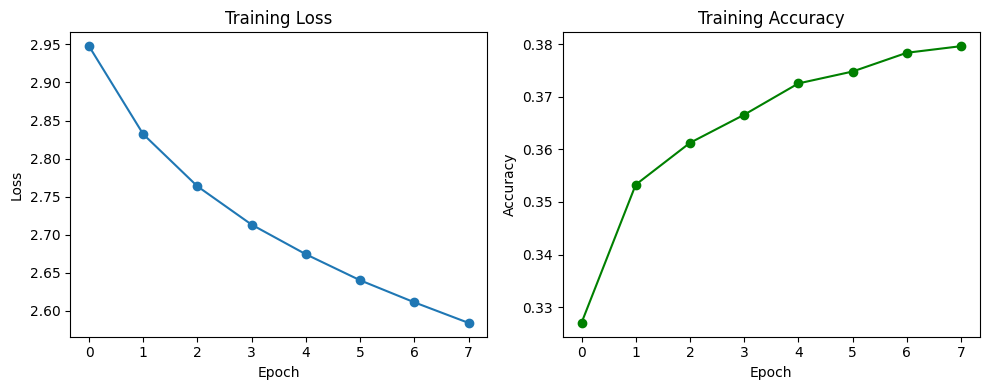

Saved checkpoint: checkpoints/epoch_8.pt


In [73]:
model = train(model=model, epochs=8)